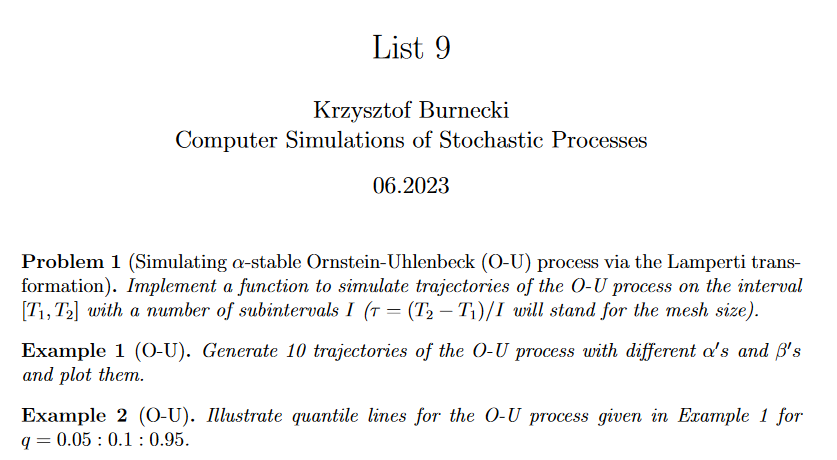

$\alpha$-stable O-U:

$Y(t) = e^{-\frac{t}{\alpha}}Z_{\alpha}(e^{t})$ -> Lamparti transformation

$Z_{\alpha}(t)$ -> $\alpha$-stable Levy motion

$t_i = T_1 + i\tau, \quad i=0,1,\ldots,I$

$Y(t_1) = e^{-\frac{t_1}{\alpha}}B(e^t)$

$B(e^{t_0}) \sim N(0, e^{t_0})$

$B(e^{t_1}) = B(e^{t_0}) + N(0, e^{t_1} - e^{t_0})$

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import levy_stable, norm
from scipy.fft import fft, irfft
import pandas as pd

In [41]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 120

HOMEWORK: ALL THAT WE DID BELOW, BUT INSTEAD OF NORMAL RVS WE PUT ALPHA STABLE RVS WITH SIGMA=(EXP(t_i) - EXP(t_i-1))^(1/alpha), alpha=2, loc=0, beta=1

In [4]:
def ornstein_uhlenbeck(T1, T2, I):
    
    tau = (T2 - T1) / I
    ts = [T1 + i*tau for i in range(I)]
    Ys = np.zeros(len(ts))
    Bs = np.zeros(len(ts))
    
    Bs[0] = np.random.normal(0, np.sqrt(np.exp(ts[0])))
    Ys[0] = np.exp(-ts[0]/2)*Bs[0]
    ksi = [np.random.normal(0, np.sqrt(np.exp(ts[j])-np.exp(ts[j-1]))) for j in range(1, I)]
    for i in range(1, len(ksi)):
        Bs[i] = Bs[i-1] + ksi[i]
        Ys[i] = np.exp(-ts[i]/2)*Bs[i]       
    
    return Ys

In [5]:
def ornstein_uhlenbeck2(T1, T2, I):
    
    tau = (T2 - T1) / I
    ts = [T1 + i*tau for i in range(I)]
    Ys = np.zeros(len(ts))
    Bs = np.zeros(len(ts))
    
    Bs[0] = levy_stable.rvs(alpha=2, beta=1, loc=0, scale=np.sqrt(np.exp(ts[0])), size=1)
    Ys[0] = np.exp(-ts[0]/2)*Bs[0]
    ksi = [levy_stable.rvs(alpha=2, beta=1, loc=0, scale=np.sqrt(np.exp(ts[j])-np.exp(ts[j-1])), size=1) for j in range(1, I)]
    for i in range(1, len(ksi)):
        Bs[i] = Bs[i-1] + ksi[i]
        Ys[i] = np.exp(-ts[i]/2)*Bs[i]       
    
    return Ys

In [6]:
def plot_ou_trajectories(N, T1, T2, I):
    trajs = np.zeros((I, N))
    tau = (T2 - T1) / I
    for i in range(N):
        trajs[:,i] = ornstein_uhlenbeck(T1, T2, I)
    
    df = pd.DataFrame(trajs)

    return df

In [7]:
def plot_ou_trajectories2(N, T1, T2, I):
    trajs = np.zeros((I, N))
    tau = (T2 - T1) / I
    for i in range(N):
        trajs[:,i] = ornstein_uhlenbeck2(T1, T2, I)
    
    df = pd.DataFrame(trajs)

    return df

In [8]:
def quantile_lines(N, T1, T2, I, qs):
    m = len(qs)
    xs_matrix = np.zeros((I, N))
    quantile_matrix = np.zeros((I, m))
    for i in range(N):
        xs_matrix[:,i] = ornstein_uhlenbeck(T1, T2, I)
    for i in range(I):
        xs = xs_matrix[i]
        xs_sorted = sorted(xs)
        quantile_matrix[i] = [xs_sorted[int(q*N)] for q in qs]
    quantile_df = pd.DataFrame(quantile_matrix, columns=[f'Q{round(q, 2)}' for q in qs])

    return quantile_df

In [9]:
def quantile_lines2(N, T1, T2, I, qs):
    m = len(qs)
    xs_matrix = np.zeros((I, N))
    quantile_matrix = np.zeros((I, m))
    for i in range(N):
        xs_matrix[:,i] = ornstein_uhlenbeck2(T1, T2, I)
    for i in range(I):
        xs = xs_matrix[i]
        xs_sorted = sorted(xs)
        quantile_matrix[i] = [xs_sorted[int(q*N)] for q in qs]
    quantile_df = pd.DataFrame(quantile_matrix, columns=[f'Q{round(q, 2)}' for q in qs])

    return quantile_df

In [104]:
ql = quantile_lines(1000, -10, 10, 1000, np.arange(0.05, 1, 0.1))
ou = plot_ou_trajectories(10, -10, 10, 1000)

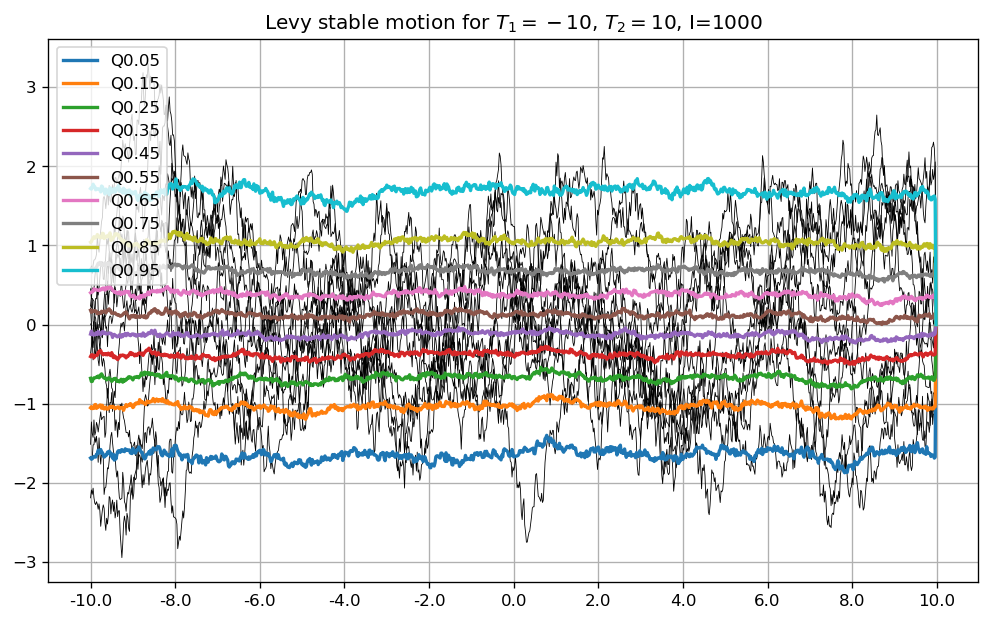

In [105]:
ax = ou.plot(legend=False, title=r'Levy stable motion for $T_1=-10$, $T_2=10$, I=1000', color='black', linewidth=0.5)
ql.plot(ax=ax, linewidth=2)
xticks = list(range(0, 1001, 100))
xtick_labels = np.linspace(-10, 10, 11)
ax.set_xticks(xticks, xtick_labels)
plt.grid()
plt.show()

In [10]:
ql2 = quantile_lines2(1000, -10, 10, 1000, np.arange(0.05, 1, 0.1))
ou2 = plot_ou_trajectories2(10, -10, 10, 1000)

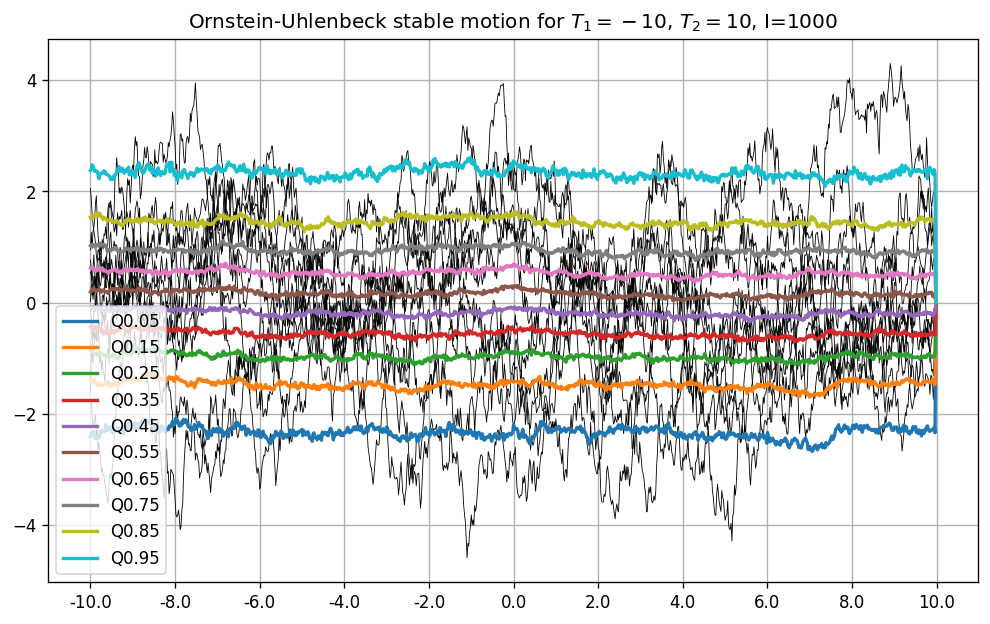

In [17]:
ax = ou2.plot(legend=False, title=r'Ornstein-Uhlenbeck stable motion for $T_1=-10$, $T_2=10$, I=1000', color='black', \
              linewidth=0.5)
ql2.plot(ax=ax, linewidth=2)
xticks = list(range(0, 1001, 100))
xtick_labels = np.linspace(-10, 10, 11)
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
plt.grid()
plt.show()

## Fractional Stable motion

In [47]:
def lfsn(H, alpha, m, M, C, n, N):
    mh = 1/m
    d = H - 1/alpha
    t0 = np.arange(mh, 1+mh, mh)
    t1 = np.arange(1+mh, M+mh, mh)
    A = mh**(1/alpha)*np.hstack((t0**d, t1**d - (t1-1)**d))
    C *= np.sum(abs(A)**alpha)**(-1/alpha)
    A *= C
    Na = m*(M+N)
    A = fft(A, Na)
    inds = np.arange(1, N*m+m, m)
    y = np.zeros((n, len(inds)))
    for i in range(n):
        if alpha < 2:
            Z = levy_stable.rvs(alpha=alpha, beta=0, loc=0, scale=1, size=Na)
        else:
            Z = np.random.normal(0, 1, Na)
        Z = fft(Z, Na)
        w = np.real(irfft(Z*A, Na))
        y[i] = w[inds]
    return y

In [49]:
lfsn(0.2, 1.5, 256, 6000, 1, 5, 1)

array([[-0.01914686,  0.06850069],
       [ 0.73444742, -0.95807975],
       [-1.07491439, -0.33404383],
       [-0.34833908,  0.04306895],
       [ 0.60495369,  1.23651193]])

In [ ]:
# lfsn(0.2, 1.5, 256, 6000, 1, 2**14 - 6000, 1)

## Fractional Brownian motion

In [29]:
def fbm(n, dt, H=0.5):
    ts = np.arange(1, n+1)*dt
    gamma = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            gamma[i, j] = 0.5 * (ts[j]**(2*H) + ts[i]**(2*H) - abs(ts[j]-ts[i])**(2*H))
    L = np.linalg.cholesky(gamma)
    Z = np.random.normal(0, 1, size=n)
    return L@Z

In [33]:
def plot_fbm_trajectories(N, n, dt, H=0.5):
    trajs = np.zeros((n, N))
    for i in range(N):
        trajs[:,i] = fbm(n, dt, H)
    df = pd.DataFrame(trajs)
    return df

In [30]:
def quantile_lines3(N, dt, n, qs, H=0.5):
    m = len(qs)
    xs_matrix = np.zeros((n, N))
    quantile_matrix = np.zeros((n, m))
    for i in range(N):
        xs_matrix[:,i] = fbm(n, dt, H)
    for i in range(n):
        xs = xs_matrix[i]
        xs_sorted = sorted(xs)
        quantile_matrix[i] = [xs_sorted[int(q*N)] for q in qs]
    quantile_df = pd.DataFrame(quantile_matrix, columns=[f'Q{round(q, 2)}' for q in qs])

    return quantile_df

In [50]:
fbm1 = plot_fbm_trajectories(100, 100, 0.01)
ql1 = quantile_lines3(100, 0.01, 100, np.arange(0.1, 0.91, 0.1))

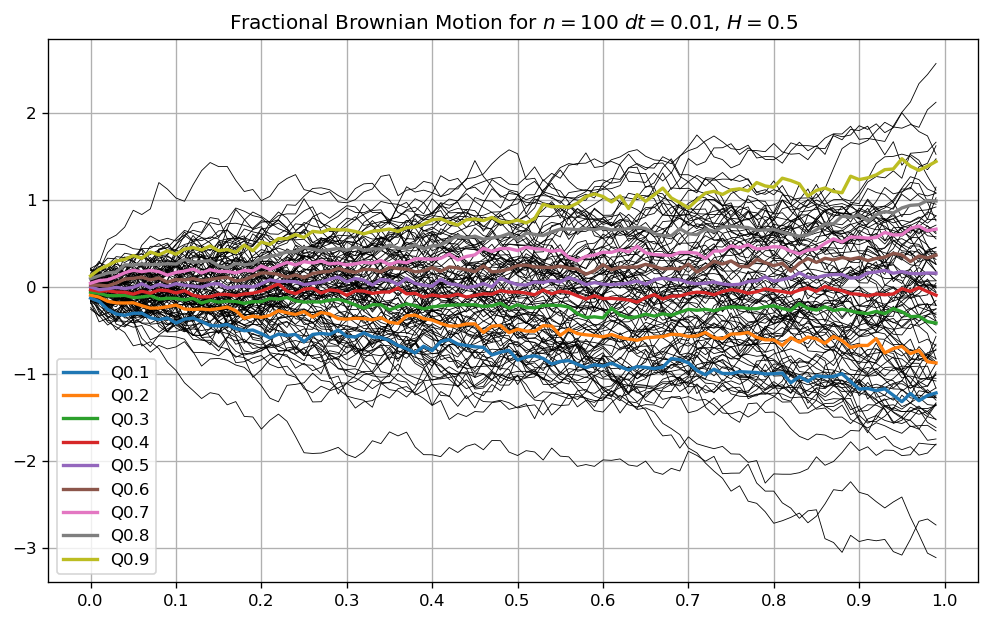

In [51]:
ax = fbm1.plot(legend=False, title=r'Fractional Brownian Motion for $n=100$ $dt=0.01$, $H=0.5$', color='black',\
               linewidth=0.5)
ql1.plot(ax=ax, linewidth=2)
xticks = list(range(0, 101, 10))
xtick_labels = [round(i,2) for i in np.arange(0, 101, 10)*0.01]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
plt.grid()
plt.show()

In [52]:
fbm2 = plot_fbm_trajectories(100, 100, 0.01, 0.3)
ql2 = quantile_lines3(100, 0.01, 100, np.arange(0.1, 0.91, 0.1), 0.3)

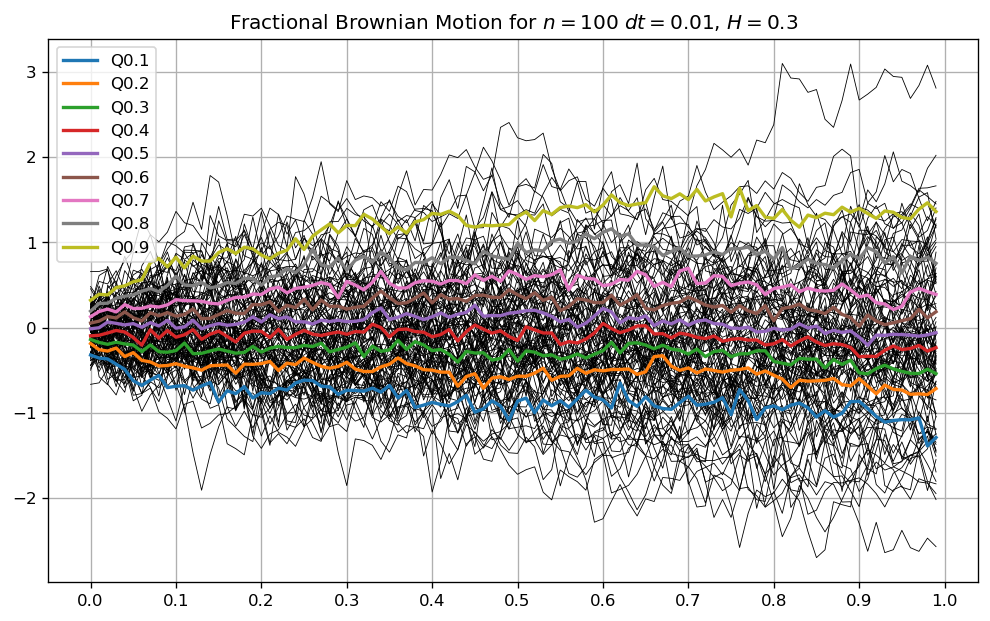

In [53]:
ax = fbm2.plot(legend=False, title=r'Fractional Brownian Motion for $n=100$ $dt=0.01$, $H=0.3$', color='black',\
               linewidth=0.5)
ql2.plot(ax=ax, linewidth=2)
xticks = list(range(0, 101, 10))
xtick_labels = [round(i,2) for i in np.arange(0, 101, 10)*0.01]
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)
plt.grid()
plt.show()